In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)

#Load the sequence data from CSV
requests = pd.read_csv('requests_every_hour.csv',header=0)

#Review loaded data
print(requests.dtypes)
requests.head()


Requests    int64
dtype: object


,Requests
0,100
1,113
2,162
3,186
4,228


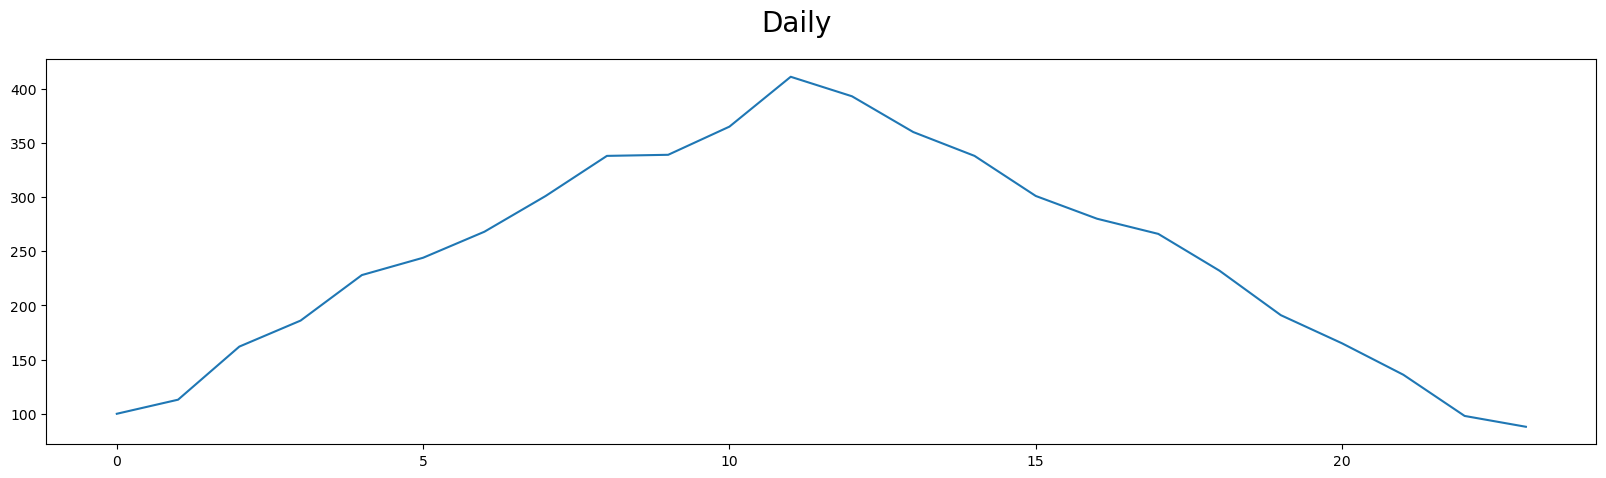

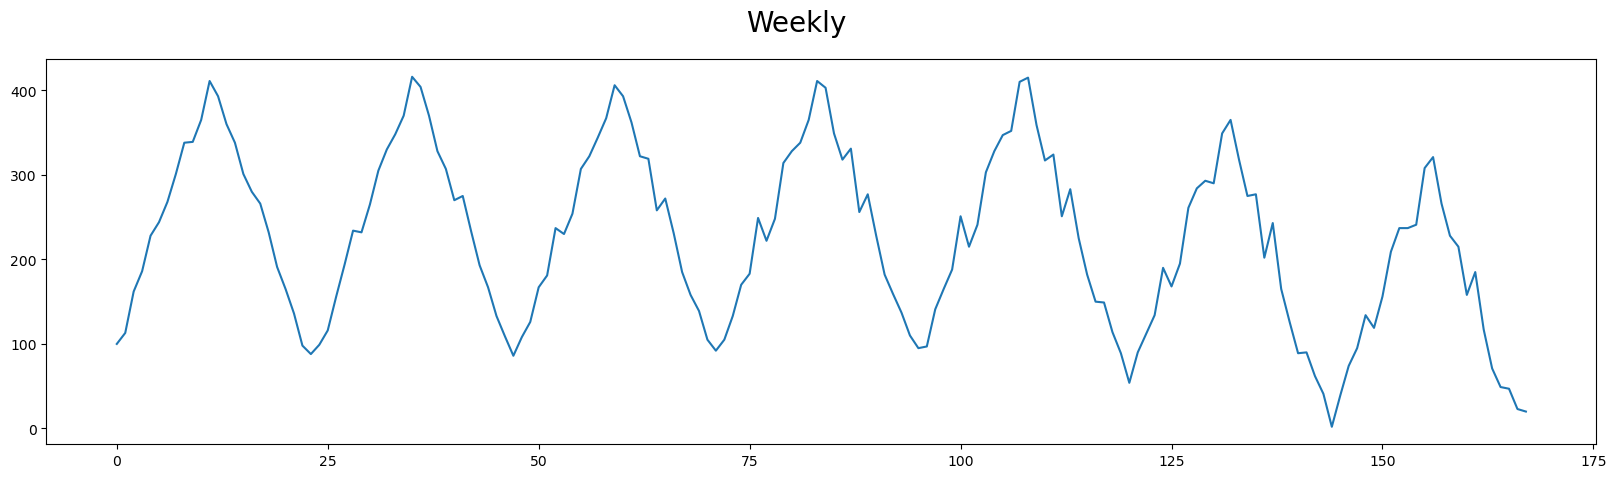

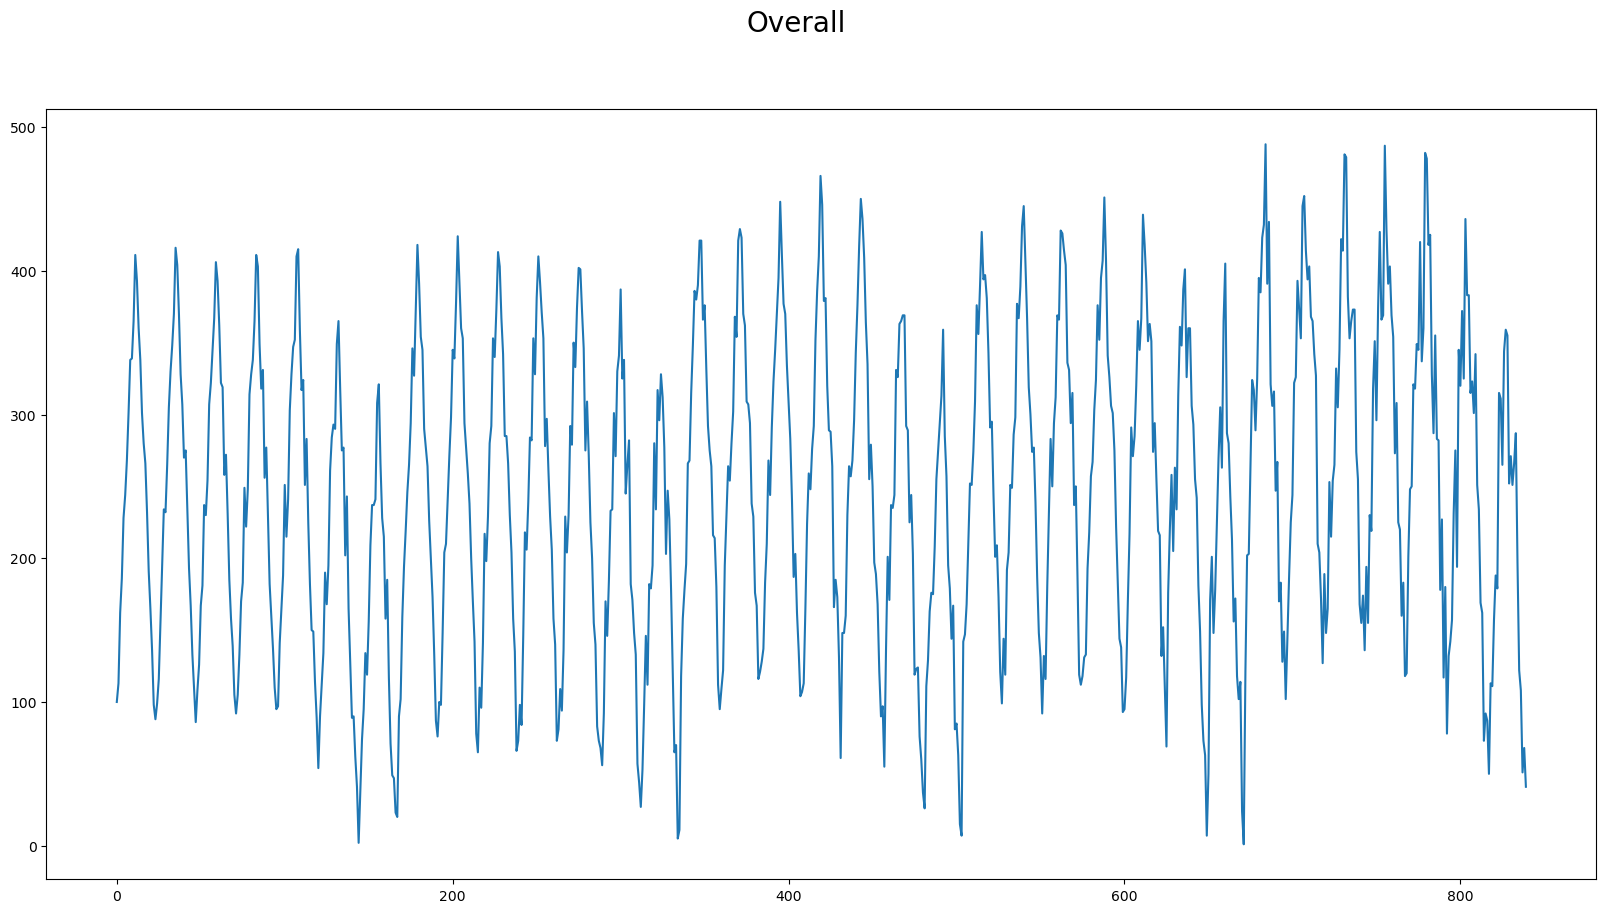

In [3]:
plt.figure(figsize=(20,5)).suptitle("Daily", fontsize=20)
plt.plot(requests.head(24))
plt.show()

plt.figure(figsize=(20,5)).suptitle("Weekly", fontsize=20)
plt.plot(requests.head(168))
plt.show()

plt.figure(figsize=(20,10)).suptitle("Overall", fontsize=20)
plt.plot(requests)
plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler

print("Request Range before scaling : " , 
          min(requests.Requests),
          max(requests.Requests))

scaler = StandardScaler()
scaled_requests=scaler.fit_transform(requests)
print("Request Range after scaling : " , 
          min(scaled_requests),
          max(scaled_requests))

#Training data has to be sequential - first 4 weeks
train_size = 24 * 7 * 4

lookback = 24 * 7

train_requests = scaled_requests[0:train_size,:]

test_requests = scaled_requests[train_size-lookback:,:]

print("\n Shaped of Train, Test : ",
      train_requests.shape, test_requests.shape)

Request Range before scaling :  1 488
Request Range after scaling :  [-2.28221282] [2.23748868]

 Shaped of Train, Test :  (672, 1) (336, 1)


In [10]:
def create_rnn_dataset(data, lookback=1):
    
    data_x, data_y = [], []
    for i in range(len(data)- lookback -1):
            #All points from this point, looking backwards upto lookback
            a = data[i:(i+ lookback), 0]
            data_x.append(a)
            #The next point
            data_y.append(data[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

#Create X and Y for training
train_req_x, train_req_y = create_rnn_dataset(train_requests,lookback)

#Reshape for use with LSTM
train_req_x = np.reshape(train_req_x, 
                         (train_req_x.shape[0],1, train_req_x.shape[1]))

print("Shapes of X, Y: ",train_req_x.shape, train_req_y.shape)

Shapes of X, Y:  (503, 1, 168) (503,)


In [12]:
from keras.models import Sequential
from keras.layers import LSTM,Dense
import tensorflow as tf

tf.random.set_seed(3)

In [16]:
ts_model=Sequential()

ts_model.add(LSTM(256, input_shape=(1,lookback)))
ts_model.add(Dense(1))

ts_model.compile(loss="mean_squared_error",
                 optimizer="adam",
                 metrics=["mse"])

ts_model.summary()

#Train the model
ts_model.fit(train_req_x, train_req_y, 
             epochs=5, batch_size=1, verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               435200    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 435457 (1.66 MB)
Trainable params: 435457 (1.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
503/503 [==============================] - 4s 5ms/step - loss: 0.1533 - mse: 0.1533
Epoch 2/5
503/503 [==============================] - 2s 4ms/step - loss: 0.0769 - mse: 0.0769
Epoch 3/5
503/503 [==============================] - 2s 4ms/step - loss: 0.0655 - mse: 0.0655
Epoch 4/5
503/503 [==============================] - 2s 4ms/step - loss: 0.0499 - mse: 0.0499
Epoch 5/5
503/503 [===================